In [64]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import napari
from FoodSeg103_data_handler import *
from scribbles_creator import create_even_scribbles
from convpaint_helpers import selfpred_convpaint
from dino_helpers import selfpred_dino
from ilastik_helpers import selfpred_ilastik

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create scribbles and predict on single image

In [65]:
img_num = 2750 #1234 #2314
img, ground_truth = load_food_data(img_num)
bin = 1.5
sq_scaling = 100
scribble_width = 3
scribbles_seed = 1
pred_seed = 123

In [66]:
np.random.seed(scribbles_seed)

scribbles = create_even_scribbles(ground_truth, max_perc=bin, sq_scaling=sq_scaling, mode="all", print_steps=False, scribble_width=scribble_width)
perc_labelled = np.sum(scribbles > 0) / np.sum(ground_truth > 0) * 100
print(f"Annotation percentage: {perc_labelled:.2f}%")

Annotation percentage: 5.25%


In [67]:
pred_ila = selfpred_ilastik(img, scribbles, random_state = pred_seed)
pred_ila = post_proc_ila_pred(pred_ila, scribbles)
acc_ila = np.sum(ground_truth == pred_ila) / np.prod(ground_truth.shape)
print(f"Accuracy Ilastik: {np.round(acc_ila*100, 2)}%")

Accuracy Ilastik: 83.87%


In [68]:
pred_conv = selfpred_convpaint(img, scribbles, random_state = pred_seed)
acc_conv = np.sum(ground_truth == pred_conv) / np.prod(ground_truth.shape)
print(f"Accuracy Convpaint: {np.round(acc_conv*100, 2)}%")

Accuracy Convpaint: 83.28%


In [69]:
pred_dino = selfpred_dino(img, scribbles, random_state = pred_seed)
acc_dino = np.sum(ground_truth == pred_dino) / np.prod(ground_truth.shape)
print(f"Accuracy DINOv2: {np.round(acc_dino*100, 2)}%")

Accuracy DINOv2: 92.59%


Show results

In [70]:
v = napari.Viewer()
v.add_image(img)
v.add_labels(ground_truth)
v.add_labels(scribbles)
v.add_labels(pred_dino)
v.add_labels(pred_conv)
v.add_labels(pred_ila)

<Labels layer 'pred_ila' at 0x20b30d11370>

## Loop over multiple images

Load the images and ground truths as batches

In [ ]:
nums = [n for n in range(0, 4900, 800)]
imgs, gts = load_food_batch(nums)
num_imgs = len(imgs)
print(f"Total images: {num_imgs}")

Check and filter for resolution

In [ ]:
resol = {im_num: np.prod(im.shape) for im_num, im in imgs.items()}
# Check for images with resolution over a certain threshold
thresh = 600_000
print("Resolutions:")
for im_num, r in resol.items(): print(f"{im_num:4d}: {r:9,d} pixels{' (!)' if r > thresh else ''}")

In [ ]:
# Filter out those images
imgs, gts = {im_num: im for im_num, im in imgs.items() if resol[im_num] < thresh}, {im_num: gt for im_num, gt in gts.items() if resol[im_num] < thresh}
num_imgs = len(imgs)
print(f"Images with resolution under {thresh:,d}: {num_imgs}")
resol_new = {im_num: np.prod(im.shape) for im_num, im in imgs.items()}
for im_num, r in resol_new.items(): print(f"{im_num:4d}: {r:7,d} pixels")

Define scribbles parameters

In [ ]:
bin=0.125
sq_scaling=100
scribble_width=3
scribbles_seed = 1
pred_seed = 123

convpaint_layers = [0]
convpaint_scalings = [1,2]

Loop, create scribbles and predict

In [ ]:
repeat_run = True
if not repeat_run:
    res_df = pd.DataFrame(columns=["img_num", 'perc. labelled', "acc_convpaint", "acc_ilastik", "acc_dino"])
    scribbles_dict = {}
for img_num, img in imgs.items():
    np.random.seed(scribbles_seed)
    print(f"IMG {img_num}")
    # Create scribbles and note its percentage
    ground_truth = gts[img_num]
    if not repeat_run:
        scribbles = create_even_scribbles(ground_truth, max_perc=bin, sq_scaling=sq_scaling, mode="all", print_steps=False, scribble_width=scribble_width)
        scribbles_dict[img_num] = scribbles
        perc_labelled = np.sum(scribbles>0) / np.prod(ground_truth.shape) * 100
    else:
        scribbles = scribbles_dict[img_num]
    # Predict with Convpaint and note its accuracy
    if True:
        pred_conv = selfpred_convpaint(img, scribbles, random_state = pred_seed)#, layer_list=convpaint_layers, scalings=convpaint_scalings)
        acc_conv = np.sum(ground_truth == pred_conv) / np.prod(ground_truth.shape)
        if not repeat_run:
            new_row = pd.DataFrame({"img_num": img_num, 'perc. labelled': perc_labelled, "acc_convpaint": acc_conv, "acc_ilastik": np.nan, "acc_dino": np.nan}, index = (0,))
            res_df = pd.concat([res_df, new_row], ignore_index=True)
        else:
            res_df.loc[res_df["img_num"] == img_num, "acc_convpaint"] = acc_conv
    # Predict with Ilastik and note its accuracy
    if True:
        pred_ila = selfpred_ilastik(img, scribbles, random_state = pred_seed)
        pred_ila = post_proc_ila_pred(pred_ila, scribbles)
        acc_ila = np.sum(ground_truth == pred_ila) / np.prod(ground_truth.shape)
        res_df.loc[res_df["img_num"] == img_num, "acc_ilastik"] = acc_ila
    # Predict with DINOv2
    if True:
        pred_dino = selfpred_dino(img, scribbles, random_state = pred_seed)
        acc_dino = np.sum(ground_truth == pred_dino) / np.prod(ground_truth.shape)
        res_df.loc[res_df["img_num"] == img_num, "acc_dino"] = acc_dino
    print("\n")

In [43]:
print(f"Accuracy Convpaint: {res_df['acc_convpaint'].mean():7.4f} (+/- {res_df['acc_convpaint'].std():.4f})")
print(f"Accuracy Ilastik: {res_df['acc_ilastik'].mean():9.4f} (+/- {res_df['acc_ilastik'].std():.4f})")
print(f"Accuracy DINOv2: {res_df['acc_dino'].mean():10.4f} (+/- {res_df['acc_dino'].std():.4f})")

res_df["diff"] = res_df["acc_convpaint"] - res_df["acc_ilastik"]
res_df = res_df.sort_values("diff", ascending=False)
print("", "Accuracy differences (Convpaint - Ilastik):", res_df["diff"].describe(), "", sep="\n")

res_df

Accuracy Convpaint:  0.8668 (+/- 0.1136)
Accuracy Ilastik:    0.7899 (+/- 0.1588)
Accuracy DINOv2:     0.9455 (+/- 0.0243)

Accuracy differences (Convpaint - Ilastik):
count    3.000000
mean     0.076851
std      0.051131
min      0.044276
25%      0.047384
50%      0.050493
75%      0.093138
max      0.135783
Name: diff, dtype: float64



,img_num,perc. labelled,acc_convpaint,acc_ilastik,acc_dino,diff
1,4000,0.390625,0.753199,0.617416,0.922684,0.135783
2,4800,0.368257,0.980446,0.929953,0.970954,0.050493
0,0,0.433350,0.866709,0.822433,0.942734,0.044276


Show the last image with ground truth, scribbles and prediction

In [44]:
v = napari.Viewer()
v.add_image(img)
v.add_labels(ground_truth)
v.add_labels(scribbles)
v.add_labels(pred_dino)
v.add_labels(pred_conv)
v.add_labels(pred_ila)

<Labels layer 'pred_ila' at 0x241d92e6d00>

## Plot

In [45]:
from matplotlib import pyplot as plt
import seaborn as sns

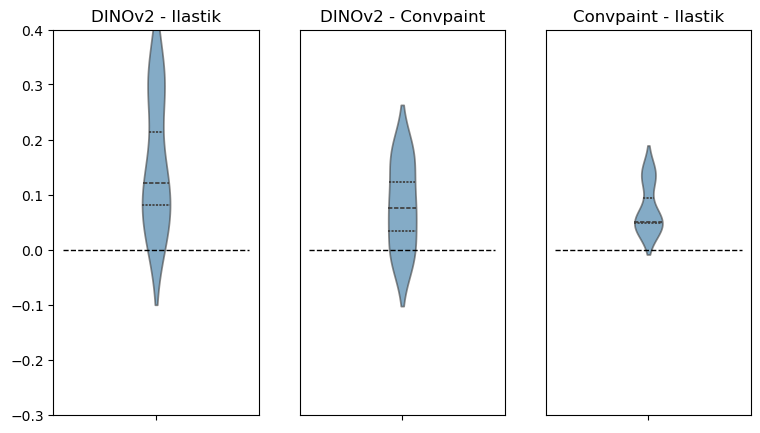

In [46]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(9, 5)
violin_args = {"alpha": 0.6, "inner": "quart", "bw_adjust": 0.65, "width": 0.3}
# fig.tight_layout()
# sns.boxplot(res_df["diff"], orient="v", color="skyblue", width=0.3, linewidth=1.5, fliersize=2.5, whis=1.5)

curr_ax = ax[2]
curr_ax.set_title("Convpaint - Ilastik")
sns.violinplot(res_df["diff"], ax=curr_ax, **violin_args)
curr_ax.set_ylabel("Accuracy diff.")

curr_ax = ax[0]
curr_ax.set_title("DINOv2 - Ilastik")
sns.violinplot(res_df["acc_dino"] - res_df['acc_ilastik'], ax=curr_ax, **violin_args)

curr_ax = ax[1]
curr_ax.set_title("DINOv2 - Convpaint")
sns.violinplot(res_df["acc_dino"] - res_df['acc_convpaint'], ax=curr_ax, **violin_args)

for a in ax:
    a.set_ylim(-0.3, 0.4)
    a.hlines(0, -1, 1, color="black", linewidth=1, linestyles='dashed')

for a in ax[1:]:
    a.set_ylabel("")
    a.set_yticks([])

plt.show()

## Properties of the dataset

In [ ]:
# Shape of the dataset
food_data_shape = (4983, 2)

#Label dictionary
id2label = {1: 'background',
            2: 'candy',
            3: 'egg tart',
            4: 'french fries',
            5: 'chocolate',
            6: 'biscuit',
            7: 'popcorn',
            8: 'pudding',
            9: 'ice cream',
            10: 'cheese butter',
            11: 'cake',
            12: 'wine',
            13: 'milkshake',
            14: 'coffee',
            15: 'juice',
            16: 'milk',
            17: 'tea',
            18: 'almond',
            19: 'red beans',
            20: 'cashew',
            21: 'dried cranberries',
            22: 'soy',
            23: 'walnut',
            24: 'peanut',
            25: 'egg',
            26: 'apple',
            27: 'date',
            28: 'apricot',
            29: 'avocado',
            30: 'banana',
            31: 'strawberry',
            32: 'cherry',
            33: 'blueberry',
            34: 'raspberry',
            35: 'mango',
            36: 'olives',
            37: 'peach',
            38: 'lemon',
            39: 'pear',
            40: 'fig',
            41: 'pineapple',
            42: 'grape',
            43: 'kiwi',
            44: 'melon',
            45: 'orange',
            46: 'watermelon',
            47: 'steak',
            48: 'pork',
            49: 'chicken duck',
            50: 'sausage',
            51: 'fried meat',
            52: 'lamb',
            53: 'sauce',
            54: 'crab',
            55: 'fish',
            56: 'shellfish',
            57: 'shrimp',
            58: 'soup',
            59: 'bread',
            60: 'corn',
            61: 'hamburg',
            62: 'pizza',
            63: 'hanamaki baozi',
            64: 'wonton dumplings',
            65: 'pasta',
            66: 'noodles',
            67: 'rice',
            68: 'pie',
            69: 'tofu',
            70: 'eggplant',
            71: 'potato',
            72: 'garlic',
            73: 'cauliflower',
            74: 'tomato',
            75: 'kelp',
            76: 'seaweed',
            77: 'spring onion',
            78: 'rape',
            79: 'ginger',
            80: 'okra',
            81: 'lettuce',
            82: 'pumpkin',
            83: 'cucumber',
            84: 'white radish',
            85: 'carrot',
            86: 'asparagus',
            87: 'bamboo shoots',
            88: 'broccoli',
            89: 'celery stick',
            90: 'cilantro mint',
            91: 'snow peas',
            92: 'cabbage',
            93: 'bean sprouts',
            94: 'onion',
            95: 'pepper',
            96: 'green beans',
            97: 'French beans',
            98: 'king oyster mushroom',
            99: 'shiitake',
            100: 'enoki mushroom',
            101: 'oyster mushroom',
            102: 'white button mushroom',
            103: 'salad',
            104: 'other ingredients'}